In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pstats
import sys
import io
import pandas as pd
import re
from matplotlib import cycler

# def set_custom_params_plt():

#     colors = cycler('color',
#                     ['#EE6666', '#3388BB', '#9988DD',
#                     '#EECC55', '#88BB44', '#FFBBBB'])
#     plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
#         axisbelow=True, grid=True)
#     plt.rc('grid', color='w', linestyle='solid')
#     plt.rc('patch', edgecolor='#E6E6E6')
#     plt.rc('lines', linewidth=2)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] #+ plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 18})
# set_custom_params_plt()

In [2]:
def processLog(f):
    with open(f, "r") as file:
        startEndPairs = []
        runtimes = []
        sfs = []
        neuroGPUStartTimes = []
        neuroGPUEndTimes = []
        procToSf = {}
        procStartDict = {}
        procEndDict = {}
        compStartDict = {}
        io_times = []
        file_lines =file.readlines()
        readingEnds = False
        readingStarts = False
        for line in file_lines:
            if "Date:" in line:
                print(line)
            if "absolute start" in line:
                numbers = re.findall(r'\d+', line)
                abs_start = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ][0]
            if "nCpus" in line:
                nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
                #assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
            if "took:" in line:
                runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
                #print(runtime)
                runtimes.append(runtime)
            if "launched PIDS" in line:
                start = re.findall(r'\d+', line)[0] # second half is in miliseconds, don't need that precision
                
            if "finished PIDS" in line:
                end = re.findall(r'\d+', line)[0] 
                startEndPairs.append((start,end))
            if "process"  in line and "started" in line:
                stSplit = line.split(" ")
                sf = [stSplit[i] for i in range(2,len(stSplit)-2) if stSplit[i-1] == "is" and  stSplit[i+1] == "and"][0]
                sfs.append(sf)
                line = re.sub(r'(?<=is)(.*)(?=and)', "", line)
                numbers = re.findall(r'\d+', line)

                procToSf[numbers[0]] = sf
                if numbers[0] in procStartDict.keys():
                    procStartDict[numbers[0]].append(numbers[1])
                else:
                    procStartDict[numbers[0]] = [numbers[1]]
            if "returning" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in procEndDict.keys():
                    procEndDict[numbers[0]].append(numbers[1])
                else:
                    procEndDict[numbers[0]] = [numbers[1]]
            if "computing" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in compStartDict.keys():
                    compStartDict[numbers[0]].append(numbers[1])
                else:
                    compStartDict[numbers[0]] = [numbers[1]]
            if "evaluation:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                evalTimes = np.array(list(numbers), dtype=np.float32)
                avgEval = np.mean(evalTimes)
            if "neuroGPU" in line and "starts" not in line and "ends" not in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                neuroGPUTimes = np.array(list(numbers),dtype=np.float32)
                avgNGPU = np.mean(neuroGPUTimes)
            if ("neuroGPU" in line and "starts" in line and "ends" not in line) or readingEnds:
                readingEnds = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUStartTimes += numbers
                if "]" in line:
                    readingEnds = False
            if ("neuroGPU" in line and "starts" not in line and "ends" in line) or readingStarts:
                readingStarts = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUEndTimes += numbers
                if "]" in line:
                    readingStarts = False
            if "IO:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                io_times.append(numbers)
#             if "gen1 took" in line:
#                 break
            
    res = {"procStartDict": procStartDict,"procEndDict": procEndDict,\
           "startEndPairs": startEndPairs,"runtimes": runtimes,\
           "compStartDict": compStartDict,"sfs": sfs,\
           "evalTimes": evalTimes,"neuroGPUTimes": neuroGPUTimes,\
          "procToSf": procToSf, "absStart": abs_start, \
           "neuroGPUStartTimes": neuroGPUStartTimes, \
           "neuroGPUEndTimes": neuroGPUEndTimes, "ioTimes": io_times}
    return res
f  = "runTimeLogs/runTime250.log".format(80,1, 1000)
logRes = processLog(f)

In [3]:
f  = "runTimeLogs/runTime.log".format(80,1, 1000)
logRes = processLog(f)
#logRes['procStartDict']
logRes['compStartDict']

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/runTime.log'

In [ ]:
# logRes["ioTimes"]
# logRes["procStartDict"]

In [ ]:
import pandas as pd

https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

24
32.66370511054993 starft 2


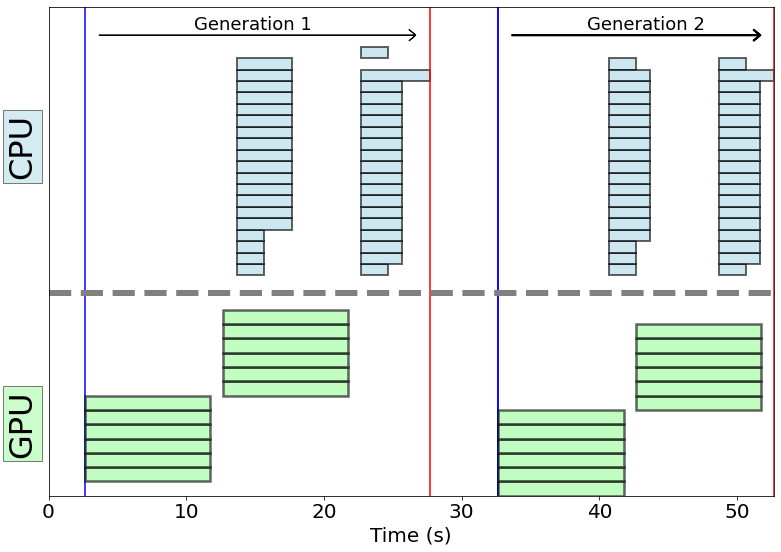

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def makeCustomProfile(nCpus,nodes,popSize, show=True):
#     f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpus,nodes, popSize)
#     f  = "outputs/80C6N_3000_0/80C6N_3000.log"
    f  = "runTimeLogs/runTime250.log"
    logRes = processLog(f)
    absStart = float(logRes['absStart'])
    start_data = np.array([float(start) for start in logRes["neuroGPUStartTimes"]]) 
    end_data = np.array(logRes["neuroGPUEndTimes"]).astype(float)
    print(len(start_data))
    times = logRes["neuroGPUTimes"]
    # bugged timer
    end_data = np.mean(times) + start_data
    procEndDict = logRes['procEndDict']
    sfsMap = logRes['procToSf']
    sfsMapMap = {}
    counter = 0
    for val in set(list(sfsMap.values())):
        sfsMapMap[val] = counter
        counter +=1

    nGpus = 6# THIS SHOULD BE IN LOG RES logRes['nGpus']
    compStartDict = logRes['compStartDict']
    procStartDict = logRes['procStartDict']
    
    startEndPairs = logRes['startEndPairs']
    #print(absStart)

    #print(startEndPairs)

    startEndPairs = [(float(pair0) - float(absStart), float(pair1) - float(absStart)) for pair0, pair1 in startEndPairs]
    #print(procStartDict)
    #print(startEndPairs)
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(13,9))
    
    # YLIM XLIM
    #plt.xlim(0,120)
    
    
    
    x_anchors= []
    x_ends = []

    def calc_y_anchor(x_anchor,width,x_anchors,x_ends):
        curr_ht = 0
        for x_anc, x_end in zip(x_anchors,x_ends):
            if x_anchor > x_anc and x_anchor < x_end:
                curr_ht += 10
            elif x_anc > x_anchor and x_anc < x_anchor+width:
                curr_ht += 10
        return curr_ht

    cur_start = 0
    y_base = 0
    firstGo = True
#     for start, end in startEndPairs:
#         if firstGo:
#             firstGo = False
#             plt.axvline(x=start,color="blue", label="CPU Eval Start")
#             plt.axvline(x=end,color="red", label="CPU Eval Done")
#         else:
#             plt.axvline(x=start,color="blue")
#             plt.axvline(x=end,color="red")
    skip = False
    
    
    for start, end in startEndPairs:
        skip = not skip
        if skip:
            continue
        if firstGo:
            firstGo = False
            plt.axvline(x=end,color="red", label="Generation Complete")
            start_x_end = end
            


            
        else:
            plt.axvline(x=end,color="red")
            end_x =end
            
    # Create a Rectangle patches
    box_ht = 25 # constant box height
    cur_start = 0
    y_base = 0
    label="Generation Start"

    for start,end,idx in zip(start_data,end_data, np.arange(len(end_data))):
        x_anchor = start-absStart
        if not y_base:
            plt.axvline(x=x_anchor,color="blue", label=label)
            label=None
            if idx == 0:
                first_start = x_anchor

        if x_anchor > float(startEndPairs[cur_start][1]):
            cur_start += 2
            y_base = 0
            plt.axvline(x=x_anchor,color="blue")
            new_start = x_anchor
            print(x_anchor, 'starft 2')
        

        else:
            y_base += box_ht
        
        y_anchor = y_base
        width =  end - start
        x_anchors.append(float(x_anchor)), x_ends.append(width)
        rect = patches.Rectangle((x_anchor, y_anchor), width, box_ht, \
                                 linewidth=2.5, edgecolor='black', facecolor='palegreen', fill=True, zorder=10, alpha=.6)
        acceptable = [0,1,5]
        if idx %  nGpus in acceptable:
            # ax.annotate("GPU {}".format(idx %  nGpus + 1), (x_anchor + 3, y_anchor + 9 ), color='black', 
            #             fontsize=13, ha='center', va='center', zorder=20)

            # Add the patch to the Axes
            ax.add_patch(rect)
        else:
            # ax.annotate("...", (x_anchor + 3, y_anchor + 12 ), color='black', 
            #             fontsize=16, ha='center', va='center', zorder=20)

            # Add the patch to the Axes
            ax.add_patch(rect)

    idx = 1
    labels = list(compStartDict.keys())
    box_ht = 20
    y_bottom = y_base + 100
    y_base = y_bottom
    prev_x_anchor = None
    max_box_ht = 0
    max_x_anchor = 0
    for procStart,procEnd,proc in \
    zip(list(procStartDict.values()),list(procEndDict.values()), list(procEndDict.keys()) ):
        for pStart,pEnd in zip(procStart,procEnd):
            x_anchor = float(pStart)  - float(absStart)#float(procStart) - float(absStart)
            y_anchor = y_base + 10
            if x_anchor > float(startEndPairs[cur_start][1]) and cur_start < len(startEndPairs) - 1 :
                cur_start += 1
                y_base = y_bottom
            elif prev_x_anchor and x_anchor >  prev_x_anchor + 5:
                y_base = y_bottom
                
                
            else:
                y_base += box_ht
            
            prev_x_anchor  = x_anchor
            max_box_ht = max(max_box_ht,y_base)
            max_x_anchor = max(max_x_anchor,x_anchor)
            if y_base > 1200: # MAX HEIGHT EXCEEDED
                #print('max height exc.')
                break
            width =(float(pEnd) - float(absStart)) - (float(pStart) - float(absStart)) #(float(procEnd) - float(absStart)) - (float(procStart) - float(absStart))
            width = max(width, 2)
            #y_anchor = calc_y_anchor(x_anchor,width,x_anchors,x_ends)
            x_anchors.append(float(x_anchor)), x_ends.append(width)
            
            rect = patches.Rectangle((x_anchor, y_anchor), width, box_ht, \
                                     linewidth=2, edgecolor='black', facecolor='lightblue', fill=True, zorder=1, alpha=.6)
            curr_sf = sfsMapMap[sfsMap[proc]]
            # ax.annotate(curr_sf, (x_anchor + 1, y_anchor + 8 ), color='black', \
            #             fontsize=13, ha='center', va='center', zorder=4)
            # Add the patch to the Axes
            ax.add_patch(rect)
            idx += 1


    max_x_anchor = max_x_anchor + width
    plt.ylim(0,max_box_ht+100)
    plt.xlim(0,max_x_anchor)
    plt.axhline(y=y_bottom - 20, xmin=0, xmax=1, linestyle='--', linewidth=6, color='grey')
    
    plt.arrow(first_start+1,max_box_ht + 50 , start_x_end - first_start-2, 0, \
              color='black', linewidth=1, fill=True, length_includes_head=True, \
              head_width=20, head_length=.5, overhang=1)
    plt.arrow(new_start+1,max_box_ht + 50 , end_x - new_start - 2, 0, \
              color='black', linewidth=2, fill=True, length_includes_head=True, \
            head_width=20, head_length=.5, overhang=1)
    ax.annotate( 'Generation 1', xy=(first_start+1 + .3 * (start_x_end - first_start-2) ,max_box_ht + 60), fontsize=18 )
    ax.annotate( 'Generation 2', xy=(new_start+1 + .3*(end_x - new_start - 2) ,max_box_ht + 60),  fontsize=18  )
    
    
    
    
    TITLE = ax.text(-3,80, 'GPU',fontsize = 32,zorder = 6, color = 'k',
                bbox={'facecolor':'palegreen', 'alpha':0.5, 'pad':4},rotation=90)
    
    TITLE = ax.text(-3,max_box_ht-.25*max_box_ht, 'CPU',fontsize = 32,zorder = 6, color = 'k',
                bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':4},rotation=90)
#     plt.title("Profile for Pop. Size 250, 12 Stims".format(nodes, popSize), size=25, pad=20)
    #plt.title("Custom Profile for {} CPUs, {} Pop Size and {} Nodes".format(nCpus,nodes,popSize))
    # plt.legend(fontsize=16, bbox_to_anchor=(.2, 1.02))
    plt.xticks(fontsize=20) 
    plt.xlabel("Time (s)", fontsize=20)
    #plt.show()
    plt.yticks([])
    plt.savefig("custom_profile_250pop_12s.png")
    
makeCustomProfile(40,4,1000)

In [29]:

def make_legend(top):
    fig, ax = plt.subplots(figsize=(8, 5))
    y = 9
    level = 0
    start = 9
    for name, val in top.items():
        ax.text(start, y - level, str(val) + "--> " + name, fontsize=20)
        level += 1

    ax.axis([0, 10, 0, 10])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.show()
# f  = "runTimeLogs/runTime.log"
# f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
logRes = processLog(f)
sfsMap = logRes['procToSf']
sfsMapMap = {}
counter = 0
for val in set(list(sfsMap.values())):
    sfsMapMap[val] = counter
    counter +=1

make_legend(sfsMapMap)
# plt.savefig("legened.png")

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/runTime.log'

In [28]:
def roofline1(nCpus,nodes,popSize, tickPos, ax, labels=False, show=True):
    #f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpus,nodes, popSize)
    f  = "runTimeLogs/runTime.log"
    logRes = processLog(f)
    absStart = float(logRes['absStart'])
    start_data = np.array([float(start) for start in logRes["neuroGPUStartTimes"]]) 
    end_data = np.array(logRes["neuroGPUEndTimes"]).astype(float)
    times = logRes["neuroGPUTimes"]
    end_data = np.mean(times) + start_data
    procEndDict = logRes['procEndDict']
    sfsMap = logRes['procToSf']


    nGpus = 8# THIS SHOULD BE IN LOG RES logRes['nGpus']
    compStartDict = logRes['compStartDict']
    procStartDict = logRes['procStartDict']
    startEndPairs = logRes['startEndPairs']
    startEndPairs = [(float(pair0) - float(absStart), float(pair1) - float(absStart)) for pair0, pair1 in startEndPairs]
    # Create figure and axes

    comp_total = 0
    i_o_total = np.sum(logRes['ioTimes'])
    comm_total = 0 
    for start, end in startEndPairs:
        for procStart, procEnd, compStart in \
        zip(list(procStartDict.values()), list(procEndDict.values()), list(compStartDict.values())):
            for idx,(pStart,pEnd,cStart) in enumerate(zip(procStart,procEnd, compStart)): 
                if float(pStart) - float(absStart) > float(start)\
                and float(pEnd) - float(absStart) <= float(end) and idx == 0: # add communication between starting map
                    comm_total += float(pStart) - float(absStart) - float(start ) 
                    comp_total += float(pEnd) - float(cStart) 
                else: # add communication between it's previous starting score function and it's run
                    comm_total += float(procStart[idx]) - float(procStart[idx-1]) 
                    comp_total += float(pEnd) - float(cStart) 
    width = 1 
    if labels:
        plt.bar(tickPos, comm_total, width, label='comm', color="grey", edgecolor='black',linewidth=1.5)
        plt.bar(tickPos, comp_total, width, bottom=comm_total,
               label='comp', color="black")
        plt.bar(tickPos, i_o_total, width, bottom=comm_total+comp_total,
               label='io', color='green')
    else:
        plt.bar(tickPos, comm_total, width, color="grey", edgecolor='black',linewidth=1.5)
        plt.bar(tickPos, comp_total, width, bottom=comm_total, color="black")
        plt.bar(tickPos, i_o_total, width, bottom=comm_total+comp_total, color='green')
    #plt.bar(["comm", "comp", "io"],[comm_total,comp_total,i_o_total])
    print(comm_total / 1000,comp_total / 1000)
    print(logRes['runtimes'] )
    return "{}C{}N_{}O".format(nCpus,nodes, popSize)
    
    
plt.figure()
exps = [[65,1,1000], [35,1,1000], [5,1,100]]
labels = []
for idx, exp in enumerate(exps):
    if idx == 0:
        labels.append(roofline1(exp[0], exp[1], exp[2],idx,ax,labels=True))
    else:
        labels.append(roofline1(exp[0], exp[1], exp[2],idx,ax))
plt.legend()
plt.xticks(ticks=np.arange(len(exps)), labels=labels)
plt.legend()
plt.title("Title goes here")
plt.ylabel("time (ms)")
#plt.savefig("plots/my_profille_{}C{}N{}".format(nCpus,nodes,popSize))
    

NameError: name 'ax' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
import re
import matplotlib.pyplot as plt

In [ ]:
def read_mixtape(path):
    with open(path,"r") as f:
        lines = [line for line in f.readlines()]
    for line in lines:
        if "Total FLOPs" in line:
            numbers = re.findall(r'\d+', line)
            total_flops = int(numbers[0])
        if "Total Bytes" in line:
            numbers = re.findall(r'\d+', line)
            total_bytes = int(numbers[0])
    return total_flops, total_bytes

        
total_flops,total_bytes = read_mixtape("mixtapes/test.txt")
AI = total_flops / total_bytes
runtime = 109
print(total_flops)
gflops = total_flops / runtime
plt.scatter(AI, gflops, label="10")


total_flops,total_bytes = read_mixtape("mixtapes/test2.txt")
AI = total_flops / total_bytes
print(total_flops)
runtime = 171.3363344669342
gflops = total_flops / runtime
plt.scatter(AI,gflops, label="40")


total_flops,total_bytes = read_mixtape("mixtapes/test3.txt")
AI = total_flops / total_bytes
runtime = 308.3363344669342
gflops = total_flops / runtime
plt.scatter(AI,gflops, label="100")


plt.legend()


440139874 / 1141923449 , 1696623459585 / 4649397433723
plt.figure()

In [ ]:
def processLog(f):
    with open(f, "r") as file:
        startEndPairs = []
        runtimes = []
        sfs = []
        neuroGPUStartTimes = []
        neuroGPUEndTimes = []
        procToSf = {}
        procStartDict = {}
        procEndDict = {}
        compStartDict = {}
        io_times = []
        file_lines =file.readlines()
        readingEnds = False
        readingStarts = False
        for line in file_lines:
            if "Date:" in line:
                print(line)
            if "absolute start" in line:
                numbers = re.findall(r'\d+', line)
                abs_start = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ][0]
            if "nCpus" in line:
                nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
                #assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
            if "took:" in line:
                runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
                #print(runtime)
                runtimes.append(runtime)
            if "launched PIDS" in line:
                start = re.findall(r'\d+', line)[0] # second half is in miliseconds, don't need that precision
                
            if "finished PIDS" in line:
                end = re.findall(r'\d+', line)[0] 
                startEndPairs.append((start,end))
            if "process"  in line and "started" in line:
                stSplit = line.split(" ")
                sf = [stSplit[i] for i in range(2,len(stSplit)-2) if stSplit[i-1] == "is" and  stSplit[i+1] == "and"][0]
                sfs.append(sf)
                line = re.sub(r'(?<=is)(.*)(?=and)', "", line)
                numbers = re.findall(r'\d+', line)

                procToSf[numbers[0]] = sf
                if numbers[0] in procStartDict.keys():
                    procStartDict[numbers[0]].append(numbers[1])
                else:
                    procStartDict[numbers[0]] = [numbers[1]]
            if "returning" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in procEndDict.keys():
                    procEndDict[numbers[0]].append(numbers[1])
                else:
                    procEndDict[numbers[0]] = [numbers[1]]
            if "computing" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in compStartDict.keys():
                    compStartDict[numbers[0]].append(numbers[1])
                else:
                    compStartDict[numbers[0]] = [numbers[1]]
            if "evaluation:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                evalTimes = np.array(list(numbers), dtype=np.float32)
                avgEval = np.mean(evalTimes)
            if "neuroGPU" in line and "starts" not in line and "ends" not in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                neuroGPUTimes = np.array(list(numbers),dtype=np.float32)
                avgNGPU = np.mean(neuroGPUTimes)
            if ("neuroGPU" in line and "starts" in line and "ends" not in line) or readingEnds:
                readingEnds = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUStartTimes += numbers
                if "]" in line:
                    readingEnds = False
            if ("neuroGPU" in line and "starts" not in line and "ends" in line) or readingStarts:
                readingStarts = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUEndTimes += numbers
                if "]" in line:
                    readingStarts = False
            if "IO:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                io_times.append(numbers)
            
            
    res = {"procStartDict": procStartDict,"procEndDict": procEndDict,\
           "startEndPairs": startEndPairs,"runtimes": runtimes,\
           "compStartDict": compStartDict,"sfs": sfs,\
           "evalTimes": evalTimes,"neuroGPUTimes": neuroGPUTimes,\
          "procToSf": procToSf, "absStart": abs_start, \
           "neuroGPUStartTimes": neuroGPUStartTimes, \
           "neuroGPUEndTimes": neuroGPUEndTimes, "ioTimes": io_times}
    return res
f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
logRes = processLog(f)

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/40C2N_1000O.log'

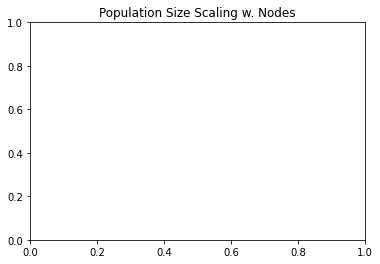

In [4]:
def plotScaling(nCpus,nodes,popSize, show=True):
    #f  = "runTimeLogs/runTime.log"
    runtimes = []
    labels = []
    for idx,(node,pop,nCpu) in enumerate(zip(nodes,pops,nCpus)):
        f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpu,node, 1000)
        logRes = processLog(f)
        runtime = np.mean(logRes['runtimes'])
        runtimes.append(runtime)
        label = "{}C{}N_{}O".format(nCpu,node, pop)
        labels.append(label)
    plt.scatter(np.arange(len(runtimes)), runtimes)
    plt.plot(np.arange(len(runtimes)), runtimes)
    plt.xticks(ticks=np.arange(len(runtimes)), labels=labels, rotation=45)
    plt.ylabel("total runtime (s)")
    
nodes = [2,3,4,5,6,8,9]
pops = [node*1000 for node in nodes]
nCpus = np.repeat(40, len(nodes))
plt.title("Population Size Scaling w. Nodes")
plotScaling(nCpus,nodes,pops)